In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path as P
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
from collections import defaultdict
import plotly.express as px
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [232]:
learning_rate=0.0001
train_size=0.99
bs=1
epochs=500

In [233]:
df=pd.read_csv('问题2-训练数据-归一化-回归.csv',index_col='time',parse_dates=True)
df['T']=100*df['year']+df['month']
# df=df.drop(columns='year')

In [234]:
YCOLS=['100cm湿度(kg/m2)', '10cm湿度(kg/m2)', '40cm湿度(kg/m2)','200cm湿度(kg/m2)']
XCOLS=['month', 'year']

X,Y=df[XCOLS].values,df[YCOLS].values

X_train,X_val,Y_train,Y_val = train_test_split(X,Y, train_size=train_size, shuffle=False)

In [235]:
X_train.shape,X_val.shape,Y_train.shape,Y_val.shape

((121, 2), (2, 2), (121, 4), (2, 4))

In [236]:
inputs = keras.layers.Input(shape=(X_train.shape[1], ))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(Y_train.shape[1])(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_81 (Dense)            (None, 128)               384       
                                                                 
 dense_82 (Dense)            (None, 128)               16512     
                                                                 
 dense_83 (Dense)            (None, 4)                 516       
                                                                 
Total params: 17,412
Trainable params: 17,412
Non-trainable params: 0
_________________________________________________________________


In [237]:
path_checkpoint = "problem2_regress_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    # 要同时保存网络结构。
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=[es_callback, modelckpt_callback],
    batch_size=bs
)

Epoch 1/500
114/121 [===========================>..] - ETA: 0s - loss: 0.1730
Epoch 1: val_loss improved from inf to 0.11428, saving model to problem2_regress_checkpoint.h5
121/121 [==============================] - 1s 6ms/step - loss: 0.1674 - val_loss: 0.1143
Epoch 2/500
110/121 [==========================>...] - ETA: 0s - loss: 0.0750
Epoch 2: val_loss improved from 0.11428 to 0.10640, saving model to problem2_regress_checkpoint.h5
121/121 [==============================] - 0s 4ms/step - loss: 0.0747 - val_loss: 0.1064
Epoch 3/500
116/121 [===========================>..] - ETA: 0s - loss: 0.0694
Epoch 3: val_loss did not improve from 0.10640
121/121 [==============================] - 0s 3ms/step - loss: 0.0694 - val_loss: 0.1094
Epoch 4/500
113/121 [===========================>..] - ETA: 0s - loss: 0.0662
Epoch 4: val_loss did not improve from 0.10640
121/121 [==============================] - 0s 3ms/step - loss: 0.0670 - val_loss: 0.1768
Epoch 5/500
104/121 [=======================

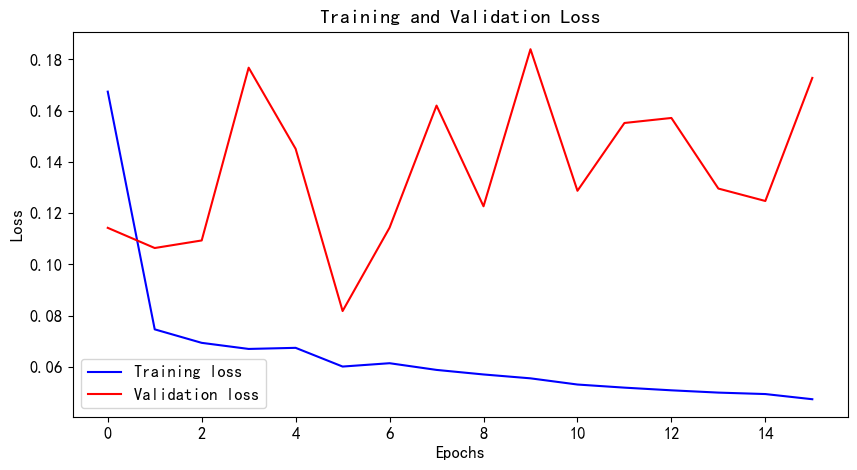

In [238]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [239]:
pred=model.predict(X)
df_pred=pd.DataFrame(data=pred, index=df.index, columns=YCOLS)
df_pred

4/4 [==============================] - 0s 4ms/step


,100cm湿度(kg/m2),10cm湿度(kg/m2),40cm湿度(kg/m2),200cm湿度(kg/m2)
time,,,,
2012-01-01,0.017606,0.118912,0.096094,0.492701
2012-02-01,0.049652,0.180984,0.140729,0.573976
2012-03-01,0.082496,0.235823,0.183489,0.638783
2012-04-01,0.116921,0.282755,0.225554,0.700243
2012-05-01,0.150206,0.324522,0.263538,0.757669
...,...,...,...,...
2021-11-01,0.632673,0.708390,0.781976,0.444147
2021-12-01,0.627505,0.677187,0.738871,0.483238
2022-01-01,0.610897,0.237891,0.593959,0.481340


In [240]:
px.line(df_pred)

In [241]:
px.line(df[YCOLS])